# Text Data I - Classification and Preprocessing

In this project, we're going to be working with a couple of new ideas.  It's important that you read all the material and ask questions if you don't understand!  The ultimate goal is to build a model that can classify tweets as positive or negative.

## Part 1: Classification

We've seen multiple types of data so far, and I mean "types" here in multiple ways.

* The data can be naturally numerical, or it can be text data.  This is what is normally meant by data type, and it can be many other things as well (for example, image data, which can be interpretted as numerical).
* The data can be _continous_ or _categorical_.

We've seen how if you want to work with categorical data, you need to binarize it.  Recall that means creating multiple columns in place of that one, where the new columns are _indicators variables_ (yes or no for being in that category) for all-but-one of the categories.  This sometimes greatly increases the number of columns in your dataset.

Up until now, however, the categorical variables were all part of the set of features/predictors, and our response (the column of data we're trying to model) has been continuous.  This is the domain of __regression__: we're trying to regress a numerical function onto our numerical data.  I've always thought that the name regression doesn't scream out "numerical response!" like I wish it did, but that's what I want you to think: we're fitting a function that relaxes the error and fits the underlying structure.  

If the response variable is a categorical variable, we're performing __classification__.  This is extremely common!  For example, a company may want to identify someone as a potential buyer or not, or a doctor may be screening for a medical condition.

### Dataset

Let's look at the iris dataset today, and attempt to perform some classification on that.  Move your files to the appropriate place to make the load work. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import exp, log
from sklearn.linear_model import LinearRegression
import seaborn as sns # makes graphs pretty, delete it if it is giving you issues
import tweepy
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import download
from nltk.util import ngrams
from collections import Counter
import re

%matplotlib inline

columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Species']
iris = pd.read_csv('data/iris.data', names=columns)
iris.head()

,Sepal length,Sepal width,Petal length,Petal width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In the Iris dataset, one would hope to use the four predictors to try and predict `Species`.  However, `Species` has three possible options, and so the first thing we want to do is make this a bit easier.  Let's take our categorical variable and make it two categories.  How do we do that?  Let's make a plot to see.

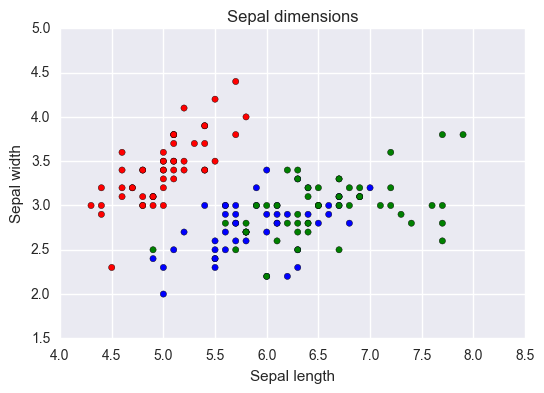

In [2]:
colorings = {'Iris-setosa':'r', 'Iris-versicolor': 'b', 'Iris-virginica': 'g'}

plt.scatter(iris['Sepal length'],iris['Sepal width'], c=iris['Species'].map(colorings))
plt.title('Sepal dimensions')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Side question: what is `map`, and how did I use it here to achieve my desired effect?  Suppose I had written a function instead of a dictionary, could I use `map`?

Map applies a function or operation to every item in the dataframe.

#### It looks reasonable to try to separate Iris Setosa from non-Iris-setosas.  

To do that, create a new column which is an indicator column for Iris Setosa.  Plot another scatter plot where points are colored by this column to double check.

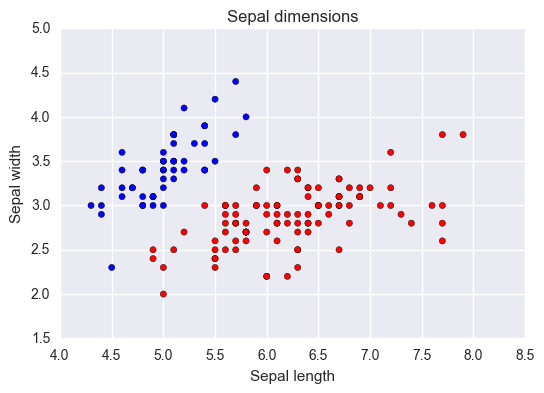

In [3]:
iris["isSet"] = iris["Species"].map({'Iris-setosa': 1, 'Iris-versicolor': 0, 'Iris-virginica': 0})
iris.head()

colorings2 = lambda val: 'b' if val is 1 else 'r'

plt.scatter(iris['Sepal length'],iris['Sepal width'], c=iris['isSet'].map(colorings2))
plt.title('Sepal dimensions')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Great.  Now, we need to train a model to output 1's and 0's instead of all possible numbers.  What we really need, then, is a function whose _range_ is within the interval $[0,1]$.  Fortunately, such functions are pretty easy to come by.  

Open up [Desmos](https://www.desmos.com/calculator) and plot the line $y=x$ along with the following function, called the __logistic function__:

$$y=\frac{1}{1+e^{-x}}$$

Describe the difference to me.  Which one is better suited to predict probabilities? Why?

The logistic function has horizontal asymptotes at y=0 and y=1, meaning that it's range is limited to (0,1). The closer you get to 1 or 0 in y, the larger a change in x would be needed.

How on earth could we use linear regression to model such a crazy function?!  The solution is to first solve the above equation for $x$, giving the __logit function__:

$$x = \ln\left(\dfrac{y}{1-y}\right).$$

Okay, let's try replacing the response with its _logit_.  Create a (python) function that you can use to take both the logistic of an `x` and the logit of a `y`.  

__IMPORTANT note__: You actually have a column of `1`s and `0`s for your `y`, and so you can't use the logit function exactly.  You need to tweak it ever so slightly:

$$x = \ln\left(\dfrac{y+0.000001}{1.000001-y}\right).$$

The number of zeroes isn't super important, you just need to bump it slightly off from the actual value, so that plugging in `1` and `0` translate to "very large number" and "the same number, but negative", respectively, instead of $+\infty$ and $-\infty$.

In [4]:
def logit(y):
    return log((y+0.000001)/(1.000001-y))
def logistic(x):
    return 1/(1+exp(-x))

Then, use `describe` to determine the effect of taking the logistic of, say, Sepal length.

In [5]:
iris["Sepal length"].map(logistic).describe()

count    150.000000
mean       0.996096
std        0.002914
min        0.986613
25%        0.993940
50%        0.996982
75%        0.998341
max        0.999629
Name: Sepal length, dtype: float64

What are you seeing when you `describe` the output?

All the values are greater than zero so they are quite close on the logistic curve with a low standard deviation.

What this means is that we first need to preprocess them a little: create a new column for each predictor, where each has the mean subtracted away to create a new mean of zero for each column.

In [6]:
for pred in columns[:-1]:
    mean_arr = iris[pred].mean()
    iris[pred+" de-meaned"] = iris[pred]-iris[pred].mean()
iris.describe()

,Sepal length,Sepal width,Petal length,Petal width,isSet,Sepal length de-meaned,Sepal width de-meaned,Petal length de-meaned,Petal width de-meaned
count,150.000000,150.000000,150.000000,150.000000,150.000000,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,5.843333,3.054000,3.758667,1.198667,0.333333,-3.315866e-16,-2.605323e-16,4.736952e-16,-9.473903e-17
std,0.828066,0.433594,1.764420,0.763161,0.472984,8.280661e-01,4.335943e-01,1.764420e+00,7.631607e-01
min,4.300000,2.000000,1.000000,0.100000,0.000000,-1.543333e+00,-1.054000e+00,-2.758667e+00,-1.098667e+00
25%,5.100000,2.800000,1.600000,0.300000,0.000000,-7.433333e-01,-2.540000e-01,-2.158667e+00,-8.986667e-01
50%,5.800000,3.000000,4.350000,1.300000,0.000000,-4.333333e-02,-5.400000e-02,5.913333e-01,1.013333e-01
75%,6.400000,3.300000,5.100000,1.800000,1.000000,5.566667e-01,2.460000e-01,1.341333e+00,6.013333e-01
max,7.900000,4.400000,6.900000,2.500000,1.000000,2.056667e+00,1.346000e+00,3.141333e+00,1.301333e+00


Now `describe` again, and tell me why this is better.  Remember: the logistic function's outputs are in the interval $(0,1)$.

Now the values from the logistic function will be distributed between 0 and 1 instead of clustered near 1.

Now let's fit a simple model that predicts only on sepal length.  It should create some equation: 

$$\ln\left(\dfrac{y}{1-y}\right) = m_{\text{length}}\cdot x_{\text{length}} + b$$

In [7]:
# You might need to change the name of your column!
X = iris['Sepal length de-meaned']
y = iris['isSet']

linreg = LinearRegression()
linreg.fit(X.reshape([-1,1]),y.apply(logit))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Make a scatter plot that colors the datapoints based on their true class (like above), but add the following code to it to show what's call the __logistic regression decision boundary__ (I'll explain in a minute, get the plot right first)

In [8]:
# Construct the decision boundary:
##   (You are welcome to try and understand what's 
##    going on in this code, but it's not something I 
##    would test you on.)
logistic_v = np.vectorize(logistic) # allows mapping the logistic function to all entries in a numpy array

mean = iris['Sepal length'].mean()  # need to de-mean the input in calculating the probability
xx, yy = np.mgrid[4.0:8.5:.01, 1.5:5.0:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logistic_v(linreg.predict((xx.T[0]-mean).reshape(-1,1)))  # forming a prediction for each point in the grid
probs_grid = np.array([probs for x in range(len(xx[0]))]).T       # shaping it appropriately

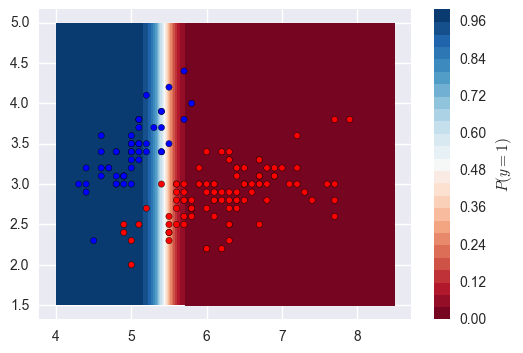

In [9]:
# Create the plot and add the decision boundary
##   (You are welcome to try and understand what's 
##    going on in this code, but it's not something I 
##    would test you on.)
figure = plt.figure()
ax = figure.add_subplot(1,1,1)
contour = ax.contourf(xx,yy, probs_grid, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour)
ax_c.set_label("$P(y = 1)$")

ax.scatter(iris['Sepal length'],iris['Sepal width'], c=iris['isSet'].map(colorings2))
ax.autoscale(tight=True)

plt.show()

Okay, so the probabilities of every point in the space are plotted using the countour plot.  I say "probabilities" here because the outputs of our model (after you pass it through the `logit` function) are between zero and one, so you can interpret the model to be outputting the _probability that the point is in class 1_.  The __decision boundary__ is typically the curve on the plane where the probability is $.5$, because that's when you would be classifying this as one class at any higher probability and the other class at any lower probability.

So what's going on here is that our model would __misclassify__ some of the points, because their probabilities are on the wrong side of the boundary.  The white dots on the blue side are wrong (they're __false positives__) and the black dots on the red side are wrong (they're __false negatives__).  But it does seem to have some idea of what's going on.  Let's add the second predictor and try to classify them again.  This is a little strange, though, because we need to output in the range of zero to one, still, and so we need to slightly tweak the `logistic` and `logit` functions to account for higher dimensions:

$$\ln\left(\dfrac{y}{1-y}\right) = m_{\text{length}}\cdot x_{\text{length}} + m_{\text{width}}\cdot x_{\text{width}} + b$$


In [10]:
# You might need to change the name of your column!
X2 = iris[['Sepal length de-meaned', 'Sepal width de-meaned']]

linreg2 = LinearRegression()
linreg2.fit(X2,y.apply(logit))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

As before, plot the points and the decision boundary:

In [11]:
# Same thing as before: construct a grid of probabilities for the decision boundary

# Construct the decision boundary:
mean_length = iris['Sepal length'].mean()
mean_width = iris['Sepal width'].mean()

xx, yy = np.mgrid[4.0:8.5:.01, 1.5:5.0:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logistic_v((linreg2.predict(np.dstack((xx-mean_length,yy-mean_width)).reshape((350*450,2)))).reshape(450,350))
# holy mole, that's some line of code.

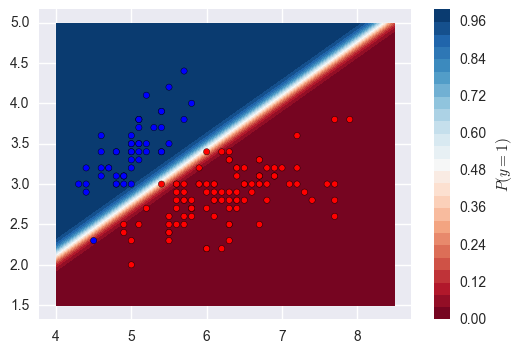

In [12]:
# Create the plot and add the decision boundary
figure = plt.figure()
ax = figure.add_subplot(1,1,1)
contour = ax.contourf(xx,yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour)
ax_c.set_label("$P(y = 1)$")

# Add your scatter plot!
ax.scatter(iris['Sepal length'],iris['Sepal width'], c=iris['isSet'].map(colorings2))
ax.autoscale(tight=True)

plt.show()

Actually, that looks great!  How close to correct were we?

### Accuracy checking

We can't "plot the residuals" in this situation.  Residuals are only defined when your response (remember, that's `y`) is continuous variable.  When you're performing classification, you need a different collection of metrics.

#### Accuracy score 

The first thing you might determine is the accuracy score: 

$$\dfrac{\text{# of correctly classified points}}{\text{# of points}}.$$  

This has some serious limitations, in a similar way to how the $R^2$ metric does for regression.  

#### Confusion matrix

A better source of information is the __confusion matrix__: 

$$\left(\begin{array}{cc} \text{True Positives} & \text{False Positives} \\
\text{False Negatives} & \text{True Negatives}\end{array}\right)$$ 

Consider an example dataset where there are almost no positives, for example trying to detect fraud.  Almost $0\%$ of transactions in the world are fraudulent, but finding fraudulent transactions is extremely important.  Why might a confusion matrix be more helpful in this situation?

In this scenario you might be more concerned with False positives and minimizing those. Therefore it would be benificial to focus on specific classifications instead of all classifications as a whole.

#### Calculate the Accuracy Score and Confusion Matrix for the above two models, then create a third model that adds the other two predictors, Petal width and Petal length.  Skip the plotting for that model, just calculate the Accuracy Score and Confusion Matrix for that as well.

In [13]:
X3 = iris[['Sepal length de-meaned', 'Sepal width de-meaned', 'Petal length de-meaned', 'Petal width de-meaned']]
linreg3 = LinearRegression()
linreg3.fit(X3,y.apply(logit))

def conf_matrix(xmat, reg):
    results = np.array([[0,0],[0,0]])
    try:
        predictions = reg.predict(xmat.reshape([-1,1]))
    except:
        predictions = reg.predict(xmat)
    for i in range(len(predictions)):
        pred = round(logistic(predictions[i]))
        if pred == 1:
            if pred == y[i]:
                results[0][0] += 1
            else:
                results[0][1] += 1
        elif pred == 0:
            if pred == y[i]:
                results[1][1] += 1
            else:
                results[1][0] += 1
    return results

def accuracy(cmat):
    return (cmat[0][0]+cmat[1][1])/cmat.sum()

cmatlist = [conf_matrix(X, linreg), conf_matrix(X2, linreg2), conf_matrix(X3, linreg3)]
for i in range(len(cmatlist)):
    print("Model %s:\nAccuracy %s\nConfusion Matrix\n%s\n" % (i+1, accuracy(cmatlist[i]), cmatlist[i]))

Model 1:
Accuracy 0.92
Confusion Matrix
[[45  7]
 [ 5 93]]

Model 2:
Accuracy 0.993333333333
Confusion Matrix
[[ 49   0]
 [  1 100]]

Model 3:
Accuracy 1.0
Confusion Matrix
[[ 50   0]
 [  0 100]]



## Part 2: Acquiring and Preprocessing Tweets

### Acquire
Using the homework as a guide, gather tweets based on your favorite hashtags, people or other things.  It could be election-specific, as that's definitely a hot topic at the moment, or anything else!  Gather at least 500 tweets from at least 5 different sources (500 total, not 2500, though feel free to gather as many as you want).  Since it's customary and helpful to put all your imports at the top, in the same cell, add `tweepy` to the top import.  Save the text of the tweet and anything else you think might help determine its sentiment, but through everything else away.

In [28]:
with open('data/twitterauth.txt') as f:
    authdata = [line.strip() for line in f]
    
auth = tweepy.OAuthHandler(authdata[0], authdata[1])
auth.set_access_token(authdata[2], authdata[3])

api = tweepy.API(auth)
names = ["elonmusk", "SpaceX", "JeffBezos", "BlueOrigin", "VirginGalactic"]
tweets = []
for name in names:
    tlist = [tweet.text for tweet in api.user_timeline(screen_name=name, count=200, include_rts=False)]
    print("%s: %s" % (name, len(tlist)))
    tweets += tlist

print("Total tweets: %s\n" % len(tweets))

for tweet in tweets:
    print(tweet, end="\n\n")

elonmusk: 143
SpaceX: 156
JeffBezos: 63
BlueOrigin: 106
VirginGalactic: 140
Total tweets: 608

Moving the Tesla announcement to Wednesday. Needs a few more days of refinement.

@markpinc @TeslaMotors thanks!

@Reuters Umm...Autobahn?

@vicentes obviously wrong

@Cocoanetics @heiseonline Not actually based on science. Objective data shows Autopilot is safer than manually driven cars.

@saufkopf87 @FortuneMagazine Utter nonsense. Empirical evidence is what matters, not random speculation.

@jovanik21 @arstechnica @drgitlin Sounds like a great move!

Good for Germany! https://t.co/SMdOL9GcTl

@hohocho That's why we need to accelerate solar power

Real fraud going on is denial of climate science. As for "subsidies", Tesla gets pennies on dollar vs coal. How about we both go to zero?

Coal-mining CEO: 'Tesla is a fraud' https://t.co/IpQJAlAo3f via @YahooFinance

Translating what actually happened in the debates... https://t.co/WW0om1rsC8

@ithrow88 @Walpoleboy6_RBX impact velocity and cente

### Process

In processing those tweets, you'll need to use `nltk` as we did in the email lab.  Don't forget to add that to the import cell.  Recall the process for preparing text data:

* Remove punctuation and other non-words,
* Stem the words and remove stop words, and
* Vectorize the words.

However, there's some differences with tweets.  Some of the tweets you gathered hopefully contain emoticons.  Look through your list of tweets and see what you find in there that is _not plain text_ and _potentially useful_.  Then, chat with your group when you're all at this point and start to build a way to pull out some of these emoticons.  Remember, our goal is to build a sentiment classifier, so anything that you think might have something to do with sentiment.

Additionally, there are fancier ways of vectorizing words.  Do the normal "Bag of Words" approach, by creating a master list of the top `N` words (try `N=5000` to start), and counting the occurance of each of the non-stop words.  But _additionally_, create a list of the top `2N` pairs of words (there are `N**2` such pairs in general, but most of those are garbage).  These pairs of words are called __2-grams__, and you can calculate $n$-grams in general.  

In [30]:
try:
    stopwords_list = stopwords.words('english')
except:
    download('stopwords')
    stopwords_list = stopwords.words('english')
    
def clean_up(text):
    return re.sub("[^a-zA-Z\s]", "", re.sub("\'|\n", " ", text)).lower()

def no_stop(intake):
    intake_list = intake.split(' ')
    full_speed = []
    for i in range(len(intake_list)):
        if intake_list[i] not in stopwords_list and intake_list[i] != "":
            full_speed.append(intake_list[i])
    return full_speed

stemmer = PorterStemmer()

def stem_all(intake):
    cleaned = no_stop(clean_up(intake))
    for i in range(len(cleaned)):
        cleaned[i] = stemmer.stem(cleaned[i])
    return cleaned

stemmed = []
ngram_list = []

for tweet in tweets:
    l = [x for x in stem_all(tweet) if not x.startswith("http")]
    stemmed += l
    ngram_list += ngrams(l,2)

count = Counter(stemmed)
#print(count.most_common(5000))

count2 = Counter(ngram_list)
count2.most_common(5000)

[(('first', 'stage'), 23),
 (('new', 'shepard'), 20),
 (('second', 'stage'), 19),
 (('vss', 'uniti'), 12),
 (('falcon', 'first'), 11),
 (('burn', 'underway'), 10),
 (('stage', 'engin'), 9),
 (('window', 'open'), 8),
 (('test', 'flight'), 8),
 (('stage', 'land'), 8),
 (('dragon', 'spacest'), 7),
 (('satellit', 'deploy'), 7),
 (('launchlandrepeat', 'blueorigin'), 7),
 (('stage', 'entri'), 7),
 (('entri', 'burn'), 7),
 (('engin', 'cutoff'), 7),
 (('transfer', 'orbit'), 7),
 (('watch', 'live'), 7),
 (('separ', 'confirm'), 6),
 (('interplanetari', 'transport'), 6),
 (('flight', 'test'), 6),
 (('launch', 'window'), 6),
 (('nasa', 'scienc'), 5),
 (('blue', 'origin'), 5),
 (('engin', 'burn'), 5),
 (('stage', 'main'), 5),
 (('pm', 'utc'), 5),
 (('stage', 'separ'), 5),
 (('look', 'forward'), 5),
 (('minut', 'launch'), 5),
 (('et', 'pm'), 5),
 (('main', 'engin'), 5),
 (('mike', 'mose'), 4),
 (('go', 'launch'), 4),
 (('cutoff', 'stage'), 4),
 (('today', 'flight'), 4),
 (('good', 'morn'), 4),
 (('l

## Part 3: Labeling your data

Now, we come to the unfortunate, but most important part, of the process.  Linear Regression (or __Logistic Regression__, what we're actually doing here) requires a __training dataset__, where its response is already known.  This sounds like fancy language, but all I mean is that the equation for linear regression has a $y$ in it:

$$\sigma = (X^T X)^{-1} X^T y$$

So in order to __train__ our model (that is, find all the $m$'s and the $b$), we need a dataset that has a known response.  All your tweets don't yet have any sentiment attached to them.  Now that part's your job.  

### Go through your list of tweets, and select at least 200 to label as positive and negative

I say 200 instead of 500 because:
* 500 would take much longer, 
* some of the tweets you downloaded might be junk, and 
* I want a relatively balanced set of positive and negative tweets from everyone.

We'll put all your labeled tweets together into a big dataset to work with next week.  

### Be sure to submit both this completed notebook and your labeled dataset as a CSV.